# Contextual Bandits with Fairness Analysis

## Resampled dataset

In [84]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB

# === 1. Load and prepare data ===
df = pd.read_csv("../../data/Xy_train_resampled.csv")

X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # type: ignore # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3, random_state=42)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  # needs 2D input
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0] # type: ignore

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy on train data: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy on train data: 0.484


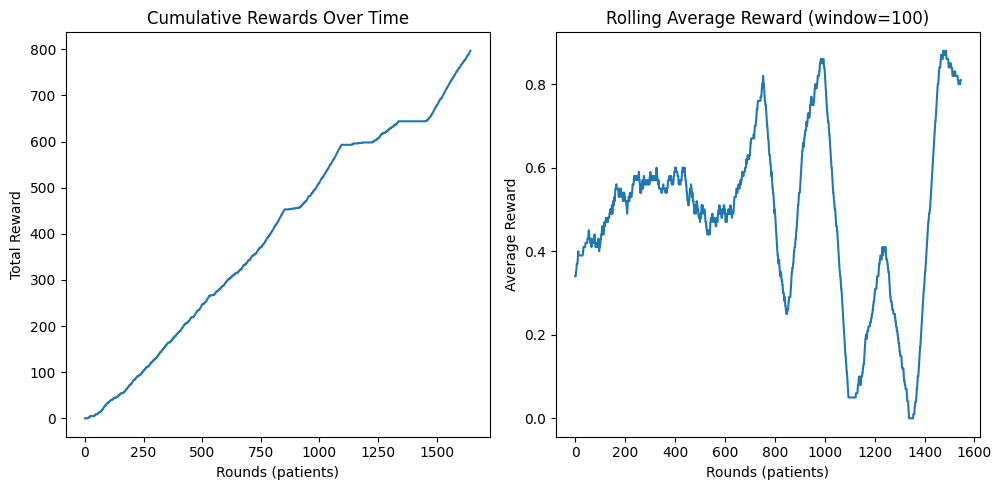

In [85]:
import numpy as np
import matplotlib.pyplot as plt

rewards = (preds == y).astype(int)  # 1 = correct prediction, 0 = incorrect

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward (for smoother curve)
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [86]:
from sklearn.metrics import accuracy_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)

score = accuracy_score(y_test, preds_test)

print("accuracy on test data: ", score)


accuracy on test data:  0.41847826086956524


In [87]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.88      0.63      0.74        82
           1       0.52      0.32      0.40        53
           2       0.11      0.18      0.13        22
           3       0.04      0.05      0.04        21
           4       0.10      0.50      0.17         6

    accuracy                           0.42       184
   macro avg       0.33      0.34      0.30       184
weighted avg       0.56      0.42      0.47       184



### Fairness evaluation on test data

In [88]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)


X_test["pred"] = preds_test       
X_test["true"] = y_test   # ground truth

# Protected attribute
protected_attr = "sex_Male"  # since it's 0/1 after encoding
groups = X_test[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = X_test[X_test[protected_attr] == g]
    n_samples = len(group_df)
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    f1 = f1_score(group_df["true"], group_df["pred"], average="macro")  
    label = "Male" if g == 1 else "Female"
    metrics[label] = {
        "accuracy": round(acc, 4),
        "recall": round(rec, 4),
        "f1": round(f1, 4),
        "n_samples": int(n_samples)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# save
import json

with open("../../results/cb_gender_resampled.json", "w") as f:
    json.dump(metrics_df.to_dict(), f, indent=4)


        accuracy  recall      f1  n_samples
Male      0.3618  0.3257  0.2906      152.0
Female    0.6875  0.2056  0.2480       32.0


/home/aniqu/.conda/envs/fairness-analysis-rl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Statistical significance test

In [89]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = X_test["sex_Male"] == 1
female_mask = X_test["sex_Male"] == 0


y_true_male = y_test[male_mask]
y_pred_male = preds_test[male_mask]
y_true_female = y_test[female_mask]
y_pred_female = preds_test[female_mask]

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -3.394, p = 0.00069
accuracy difference significant


## Original dataset

In [90]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB
from sklearn.preprocessing import StandardScaler

# === 1. Load and prepare data ===
X_train = pd.read_csv('../../data/X_train.csv')
y_train = pd.read_csv('../../data/y_train.csv')
df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # type: ignore # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3, random_state=42)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0] # type: ignore

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy on train data: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy on train data: 0.492


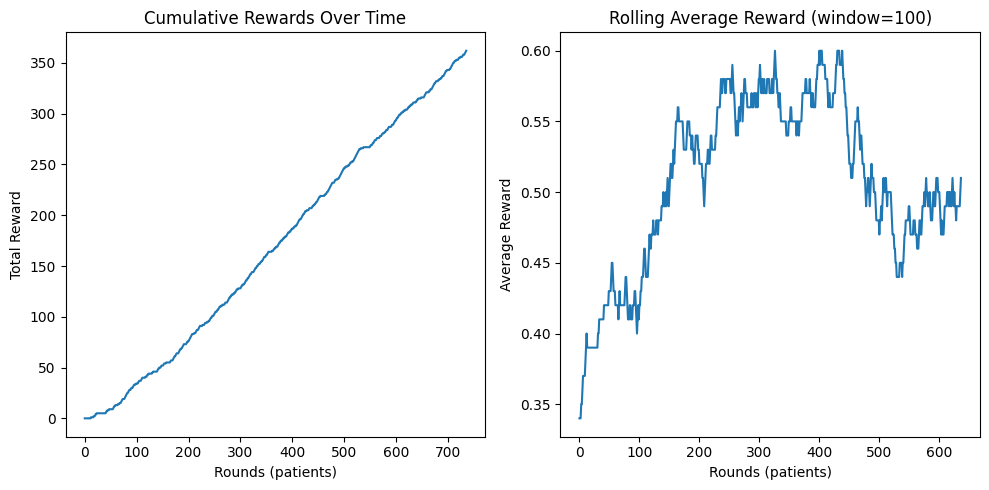

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# results = bandit.fit_predict(X, y)
# or evaluate(X, y)

rewards = (preds == y).astype(int)  # 1 = correct prediction, 0 = incorrect

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward (for smoother curve)
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [92]:
from sklearn.metrics import accuracy_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)

score = accuracy_score(y_test, preds_test)

print("accuracy on test data: ", score)


accuracy on test data:  0.5217391304347826


In [93]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        82
           1       0.42      0.47      0.45        53
           2       0.00      0.00      0.00        22
           3       0.20      0.29      0.24        21
           4       0.00      0.00      0.00         6

    accuracy                           0.52       184
   macro avg       0.28      0.31      0.29       184
weighted avg       0.50      0.52      0.51       184



### Fairness evaluation on test data

In [94]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)


X_test["pred"] = preds_test      
X_test["true"] = y_test   # ground truth

# Protected attribute
protected_attr = "sex_Male"  # since it's 0/1 after encoding
groups = X_test[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = X_test[X_test[protected_attr] == g]
    n_samples = len(group_df)
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  # across all 5 classes
    f1 = f1_score(group_df["true"], group_df["pred"], average="macro")  
    label = "Male" if g == 1 else "Female"
    metrics[label] = {
        "accuracy": round(acc, 4),
        "recall": round(rec, 4),
        "f1": round(f1, 4),
        "n_samples": int(n_samples)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# save
with open("../../results/cb_gender_original.json", "w") as f:
    json.dump(metrics_df.to_dict(), f, indent=4)

        accuracy  recall      f1  n_samples
Male      0.4605  0.3006  0.2859      152.0
Female    0.8125  0.2940  0.3029       32.0


/home/aniqu/.conda/envs/fairness-analysis-rl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [95]:
X_test.groupby("sex_Male")["true"].value_counts()

sex_Male  true
0         0       27
          1        4
          2        1
1         0       55
          1       49
          2       21
          3       21
          4        6
Name: count, dtype: int64

In [96]:
print(X_test.groupby(["sex_Male", "pred"])["pred"].count())


sex_Male  pred
0         0       27
          1        3
          3        2
1         0       55
          1       56
          2        5
          3       28
          4        8
Name: pred, dtype: int64


#### Statistical significance

In [97]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = X_test["sex_Male"] == 1
female_mask = X_test["sex_Male"] == 0


y_true_male = y_test[male_mask]
y_pred_male = preds_test[male_mask]
y_true_female = y_test[female_mask]
y_pred_female = preds_test[female_mask]

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -3.623, p = 0.00029
accuracy difference significant


## With age groups (original dataset)

In [98]:
df = pd.read_csv('../../data/age_analysis/Xy_test_age_analysis.csv')
df.rename(columns={'num':'true'}, inplace=True)
df['pred'] = preds_test

In [99]:
from sklearn.metrics import accuracy_score, recall_score

results = {}

for group in df['age_group'].unique():
    mask = df['age_group'] == group
    y_true = df.loc[mask, 'true']
    y_pred = df.loc[mask, 'pred']

    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    n_samples = len(y_true)

    results[group] = {'accuracy': acc, 'recall': rec, 'f1': f1, 'n_samples': n_samples}

age_results = pd.DataFrame(results).T
order = [0, 3, 2, 1]
age_results_ordered = age_results.iloc[order]
print(age_results_ordered)

with open("../../results/cb_age_original.json", "w") as f:
    json.dump(age_results_ordered.to_dict(), f, indent=4)


       accuracy    recall        f1  n_samples
<40    0.777778  0.708333  0.723077       18.0
40-50  0.777778  0.346465  0.324242       36.0
50-60  0.525000  0.353968  0.324726       80.0
60+    0.240000  0.188156  0.188444       50.0


/home/aniqu/.conda/envs/fairness-analysis-rl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Test significance

In [100]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import itertools
import json

age_groups = ["<40", "40-50", "50-60", "60+"]
results = []

for g1, g2 in itertools.combinations(age_groups, 2):
    mask_1 = df["age_group"] == g1
    mask_2 = df["age_group"] == g2

    y_true_1 = df.loc[mask_1, "true"]
    y_pred_1 = df.loc[mask_1, "pred"]
    y_true_2 = df.loc[mask_2, "true"]
    y_pred_2 = df.loc[mask_2, "pred"]

    acc_1 = (y_pred_1.to_numpy() == y_true_1.to_numpy()).astype(int)
    acc_2 = (y_pred_2.to_numpy() == y_true_2.to_numpy()).astype(int)

    count = np.array([acc_1.sum(), acc_2.sum()])
    nobs = np.array([len(acc_1), len(acc_2)])
    stat, pval = proportions_ztest(count, nobs)

    acc_rate_1 = acc_1.mean()
    acc_rate_2 = acc_2.mean()
    
    result = {
        "comparison": f"{g1} vs {g2}",
        "accuracy_1": f"{acc_rate_1:.6f}",
        "accuracy_2": f"{acc_rate_2:.6f}",
        "z_stat": f"{stat:.6f}",
        "p_value": f"{pval:.8f}",
        "significant": bool(pval < 0.05)
    }
    results.append(result)

    # print to console
    symbol = "✅" if pval < 0.05 else "❌"
    print(f"{g1} vs {g2}: z = {stat:.4f}, p = {pval:.6f} → {symbol} ")

with open("../../results/cb_age_original_significance.json", "w") as f:
    json.dump(results, f, indent=2)


<40 vs 40-50: z = 0.0000, p = 1.000000 → ❌ 
<40 vs 50-60: z = 1.9580, p = 0.050229 → ❌ 
<40 vs 60+: z = 4.0259, p = 0.000057 → ✅ 
40-50 vs 50-60: z = 2.5748, p = 0.010031 → ✅ 
40-50 vs 60+: z = 4.9326, p = 0.000001 → ✅ 
50-60 vs 60+: z = 3.2081, p = 0.001336 → ✅ 


## Train dataset analysis

## Original

In [101]:
df = pd.read_csv('../../data/X_train.csv')
sex = df['sex_Male']
sex.value_counts()

sex_Male
1    574
0    162
Name: count, dtype: int64

## Resambled

In [102]:
df_resampled = pd.read_csv('../../data/Xy_train_resampled.csv')
sex_resampled = df_resampled['sex_Male']
sex_resampled.value_counts()

sex_Male
1    1347
0     298
Name: count, dtype: int64

/tmp/ipykernel_57854/1038308546.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_by_gender_train.index.astype(str), y=acc_by_gender_train['accuracy'], palette='Set2')


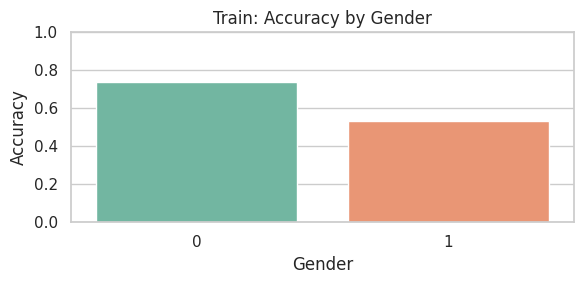

/tmp/ipykernel_57854/1038308546.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_by_gender_test.index.astype(str), y=acc_by_gender_test['accuracy'], palette='Set2')


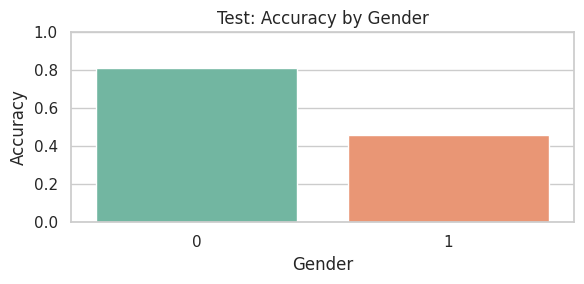

/tmp/ipykernel_57854/1038308546.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_acc_train.index, y=age_acc_train['accuracy'], palette='pastel')


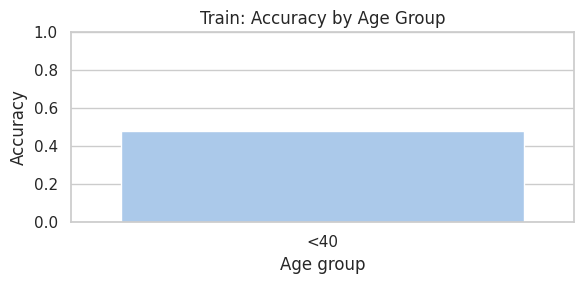

/tmp/ipykernel_57854/1038308546.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_acc_test.index, y=age_acc_test['accuracy'], palette='pastel')


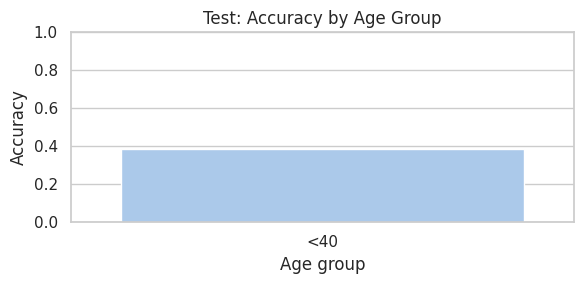

/tmp/ipykernel_57854/1038308546.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rec_df.index.astype(str), y=rec_df.values, palette='Set1')


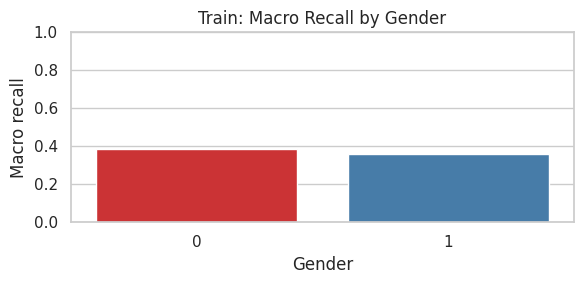

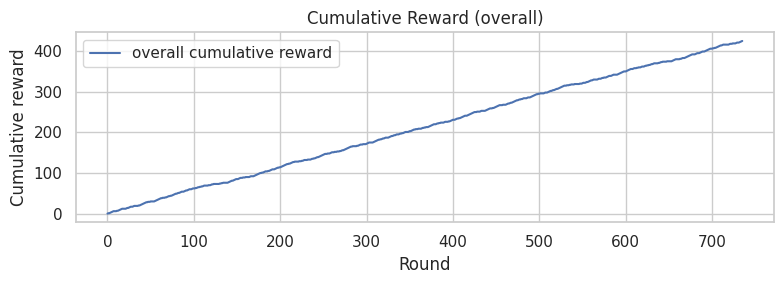

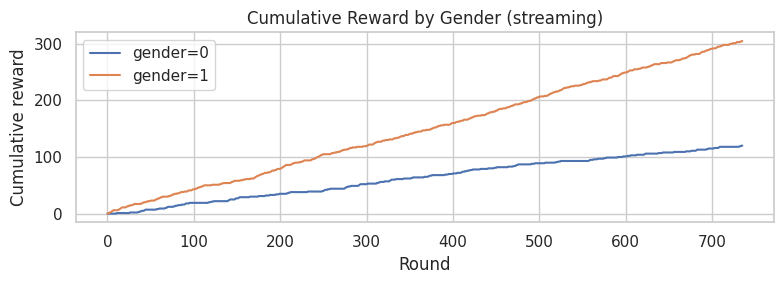

KeyError: nan

In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

sns.set(style="whitegrid")


df_train = pd.read_csv("../../data/X_train.csv")
y_train = pd.read_csv("../../data/y_train.csv")
df_train['pred'] = policy.predict(df_train)
df_train['true'] = y_train['num']

df_test = pd.read_csv("../../data/X_test.csv")
y_test = pd.read_csv("../../data/y_test.csv")
df_test['pred'] = policy.predict(df_test)
df_test['true'] = y_test['num']

# detect gender and age columns
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

gender_col = find_col(df_train, ['sex_Male','sex','gender','Sex'])
age_col = find_col(df_train, ['age'])

# --- 1) Male vs Female Accuracy (train and optionally test) ---
def group_accuracy(df, group_col, pred_col='pred', true_col='true'):
    out = {}
    if group_col is None or group_col not in df.columns:
        return None
    for g in sorted(df[group_col].unique()):
        mask = df[group_col] == g
        out[g] = {'n': int(mask.sum()), 'accuracy': float(accuracy_score(df.loc[mask,true_col], df.loc[mask,pred_col]))}
    return pd.DataFrame(out).T

acc_by_gender_train = group_accuracy(df_train, gender_col)
if df_test is not None:
    acc_by_gender_test = group_accuracy(df_test, gender_col)
else:
    acc_by_gender_test = None

if acc_by_gender_train is not None:
    plt.figure(figsize=(6,3))
    sns.barplot(x=acc_by_gender_train.index.astype(str), y=acc_by_gender_train['accuracy'], palette='Set2')
    plt.ylim(0,1); plt.title('Train: Accuracy by Gender'); plt.xlabel('Gender'); plt.ylabel('Accuracy'); plt.tight_layout(); plt.show()
if acc_by_gender_test is not None:
    plt.figure(figsize=(6,3))
    sns.barplot(x=acc_by_gender_test.index.astype(str), y=acc_by_gender_test['accuracy'], palette='Set2')
    plt.ylim(0,1); plt.title('Test: Accuracy by Gender'); plt.xlabel('Gender'); plt.ylabel('Accuracy'); plt.tight_layout(); plt.show()

# --- 2) Accuracy by Age Group (bins: <40, 40-60, 60+) ---
def ensure_age_group(df):
    if 'age_group' in df.columns:
        return df
    if 'age' in df.columns:
        df = df.copy()
        df['age_group'] = pd.cut(df['age'], bins=[0,40,60,200], labels=['<40','40-60','60+'])
        return df
    return None

df_train_age = ensure_age_group(df_train)
df_test_age = ensure_age_group(df_test) if df_test is not None else None

def acc_by_age(df):
    if df is None: return None
    res = {}
    for g in df['age_group'].cat.categories:
        mask = df['age_group'] == g
        if mask.sum()==0: continue
        res[str(g)] = {'n': int(mask.sum()), 'accuracy': float(accuracy_score(df.loc[mask,'true'], df.loc[mask,'pred']))}
    return pd.DataFrame(res).T

age_acc_train = acc_by_age(df_train_age)
age_acc_test = acc_by_age(df_test_age)

if age_acc_train is not None:
    plt.figure(figsize=(6,3))
    sns.barplot(x=age_acc_train.index, y=age_acc_train['accuracy'], palette='pastel')
    plt.ylim(0,1); plt.title('Train: Accuracy by Age Group'); plt.xlabel('Age group'); plt.ylabel('Accuracy'); plt.tight_layout(); plt.show()
if age_acc_test is not None:
    plt.figure(figsize=(6,3))
    sns.barplot(x=age_acc_test.index, y=age_acc_test['accuracy'], palette='pastel')
    plt.ylim(0,1); plt.title('Test: Accuracy by Age Group'); plt.xlabel('Age group'); plt.ylabel('Accuracy'); plt.tight_layout(); plt.show()

# --- 3) Recall by Gender (macro recall) ---
if gender_col is not None:
    recalls = {}
    for g in sorted(df_train[gender_col].unique()):
        mask = df_train[gender_col] == g
        recalls[g] = recall_score(df_train.loc[mask,'true'], df_train.loc[mask,'pred'], average='macro', zero_division=0)
    rec_df = pd.Series(recalls).rename('macro_recall')
    plt.figure(figsize=(6,3))
    sns.barplot(x=rec_df.index.astype(str), y=rec_df.values, palette='Set1')
    plt.ylim(0,1); plt.title('Train: Macro Recall by Gender'); plt.xlabel('Gender'); plt.ylabel('Macro recall'); plt.tight_layout(); plt.show()

# --- 4) Cumulative Reward per Context or Policy (train streaming) ---
# use df_train order to simulate online rounds; need reward column or compare pred==true
if 'reward' in df_train.columns:
    df_train['reward'] = df_train['reward'].astype(int)
else:
    df_train['reward'] = (df_train['pred'] == df_train['true']).astype(int)

# overall cumulative
df_train['cum_reward_overall'] = df_train['reward'].cumsum()
plt.figure(figsize=(8,3))
plt.plot(df_train['cum_reward_overall'], label='overall cumulative reward')
plt.xlabel('Round'); plt.ylabel('Cumulative reward'); plt.title('Cumulative Reward (overall)'); plt.legend(); plt.tight_layout(); plt.show()

# cumulative per gender (streaming)
if gender_col is not None:
    groups = sorted(df_train[gender_col].unique())
    cum = {g:[] for g in groups}
    counts = {g:0 for g in groups}
    for _, row in df_train.iterrows():
        g = row[gender_col]
        counts[g] += int(row['reward'])
        for gg in groups:
            cum[gg].append(counts[gg])
    plt.figure(figsize=(8,3))
    for g in groups:
        plt.plot(cum[g], label=f'gender={g}')
    plt.title('Cumulative Reward by Gender (streaming)'); plt.xlabel('Round'); plt.ylabel('Cumulative reward'); plt.legend(); plt.tight_layout(); plt.show()

# cumulative per age group if available
if df_train_age is not None:
    groups = df_train_age['age_group'].cat.categories
    cum = {g:[] for g in groups}
    counts = {g:0 for g in groups}
    for _, row in df_train_age.iterrows():
        g = row['age_group']
        counts[g] += int(row['reward'])
        for gg in groups:
            cum[gg].append(counts[gg])
    plt.figure(figsize=(8,3))
    for g in groups:
        plt.plot(cum[g], label=str(g))
    plt.title('Cumulative Reward by Age Group (streaming)'); plt.xlabel('Round'); plt.ylabel('Cumulative reward'); plt.legend(); plt.tight_layout(); plt.show()

# --- 5) Proportion of Correct Actions by Context ---
# compute for gender: for each predicted action, proportion correct among that context
def prop_correct_by_context(df, context_col, action_col='pred', true_col='true'):
    if context_col is None or context_col not in df.columns:
        return None
    rows = []
    for g in sorted(df[context_col].unique()):
        sub = df[df[context_col]==g]
        for a in sorted(sub[action_col].unique()):
            mask = sub[action_col]==a
            prop = (sub.loc[mask, action_col] == sub.loc[mask, true_col]).mean()
            rows.append({'context':g, 'action':a, 'prop_correct': float(prop), 'n': int(mask.sum())})
    return pd.DataFrame(rows)

if gender_col is not None:
    pc_gender = prop_correct_by_context(df_train, gender_col)
    plt.figure(figsize=(7,3))
    sns.barplot(data=pc_gender, x='action', y='prop_correct', hue='context', palette='Set2')
    plt.ylim(0,1); plt.title('Proportion Correct (by predicted action) — Gender'); plt.xlabel('Predicted action'); plt.ylabel('Proportion correct'); plt.tight_layout(); plt.show()

if df_train_age is not None:
    pc_age = prop_correct_by_context(df_train_age, 'age_group')
    plt.figure(figsize=(8,3))
    sns.barplot(data=pc_age, x='action', y='prop_correct', hue='context', palette='pastel')
    plt.ylim(0,1); plt.title('Proportion Correct (by predicted action) — Age group'); plt.xlabel('Predicted action'); plt.ylabel('Proportion correct'); plt.tight_layout(); plt.show()

# --- End ---
print("Done: generated graphs for gender/age/recall/cumulative reward/proportion-correct.")